In [34]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchsummary import summary
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import time
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50
from torchvision.io import decode_image, encode_jpeg
import glob
import os
import matplotlib.pyplot as plt

Detect device in use

In [35]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Load images with labels already converted from JSON using labelme.

In [3]:
in_file_path = '/lcrc/group/earthscience/rjackson/lakebreeze_summer_2023/*.png'
def decode_images(file_path):
    img_list = glob.glob(in_file_path)
    label = []
    image = []
    for img in img_list:
        if not os.path.exists(os.path.join(img[:-3], 'label.png')):
            label.append(torch.zeros((256, 256)))
        else:
            temp_img = decode_image(os.path.join(img[:-3], 'label.png'))
            rgb_image = temp_img[:, :, :].sum(axis=0)
            rgb_image[rgb_image > 0] = 1.
            label.append(rgb_image)
        my_img = decode_image(img)
        my_img = my_img[:3, :, :]
        image.append(decode_image(encode_jpeg(my_img)))
    
    transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    label = torch.stack(label).int()
    image = transform(torch.stack(image).float())
    
    return TensorDataset(image, label)

Load the images into a tensor dataset.

In [4]:
input_dataset = decode_images(in_file_path)

Train-test split (80/20)

In [36]:
random_gen = torch.Generator().manual_seed(42)
datasets = random_split(input_dataset, [0.8, 0.2], generator=random_gen)
train_dataset = datasets[0]
test_dataset = datasets[1]

Use a fully connected resnet50 model with 2 classes.

In [39]:
model = fcn_resnet50(num_classes=2)
# Set the model to run on the device
model = model.to(device)

learning_rate = 0.0001
num_epochs = 100
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

Train the model.

In [40]:
prev_validation_loss = np.inf
num_epochs_till_stop = 10
num_epochs_no_improvement = 0
for epoch in range(num_epochs):
    for image, target in dataloader:
        image = image.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output['out'], target.long())
        loss.backward()
        optimizer.step()
    # Print the loss for every epoch
    validation_loss = 0
    with torch.no_grad():
        for image, target in dataloader_test:
            image = image.to(device)
            target = target.to(device)
            output_test = model(image)
            validation_loss += criterion(output_test['out'], target.long()).item() * image.size(0)
    validation_loss = validation_loss / len(dataloader_test.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Validation loss: {validation_loss:.4f}')  
    torch.save(model, f'models/epoch{epoch}.pickle')
    if validation_loss > prev_validation_loss:
        num_epochs_no_improvement += 1
    if num_epochs_no_improvement == num_epochs_till_stop:
        break

Epoch 1/100, Loss: 0.0187, Validation loss: 0.0232
Epoch 2/100, Loss: 0.0130, Validation loss: 0.0152
Epoch 3/100, Loss: 0.0137, Validation loss: 0.0109
Epoch 4/100, Loss: 0.0155, Validation loss: 0.0091
Epoch 5/100, Loss: 0.0061, Validation loss: 0.0080
Epoch 6/100, Loss: 0.0086, Validation loss: 0.0076
Epoch 7/100, Loss: 0.0060, Validation loss: 0.0067
Epoch 8/100, Loss: 0.0064, Validation loss: 0.0065
Epoch 9/100, Loss: 0.0047, Validation loss: 0.0064
Epoch 10/100, Loss: 0.0020, Validation loss: 0.0062
Epoch 11/100, Loss: 0.0063, Validation loss: 0.0062
Epoch 12/100, Loss: 0.0047, Validation loss: 0.0062
Epoch 13/100, Loss: 0.0033, Validation loss: 0.0064
Epoch 14/100, Loss: 0.0038, Validation loss: 0.0063
Epoch 15/100, Loss: 0.0017, Validation loss: 0.0063
Epoch 16/100, Loss: 0.0024, Validation loss: 0.0065
Epoch 17/100, Loss: 0.0031, Validation loss: 0.0063
Epoch 18/100, Loss: 0.0033, Validation loss: 0.0064
Epoch 19/100, Loss: 0.0022, Validation loss: 0.0067
Epoch 20/100, Loss: 0

KeyboardInterrupt: 

Check model outputs.

(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(32, 2, 256, 256)
(28, 2, 256, 256)


IndexError: index 28 is out of bounds for axis 0 with size 28

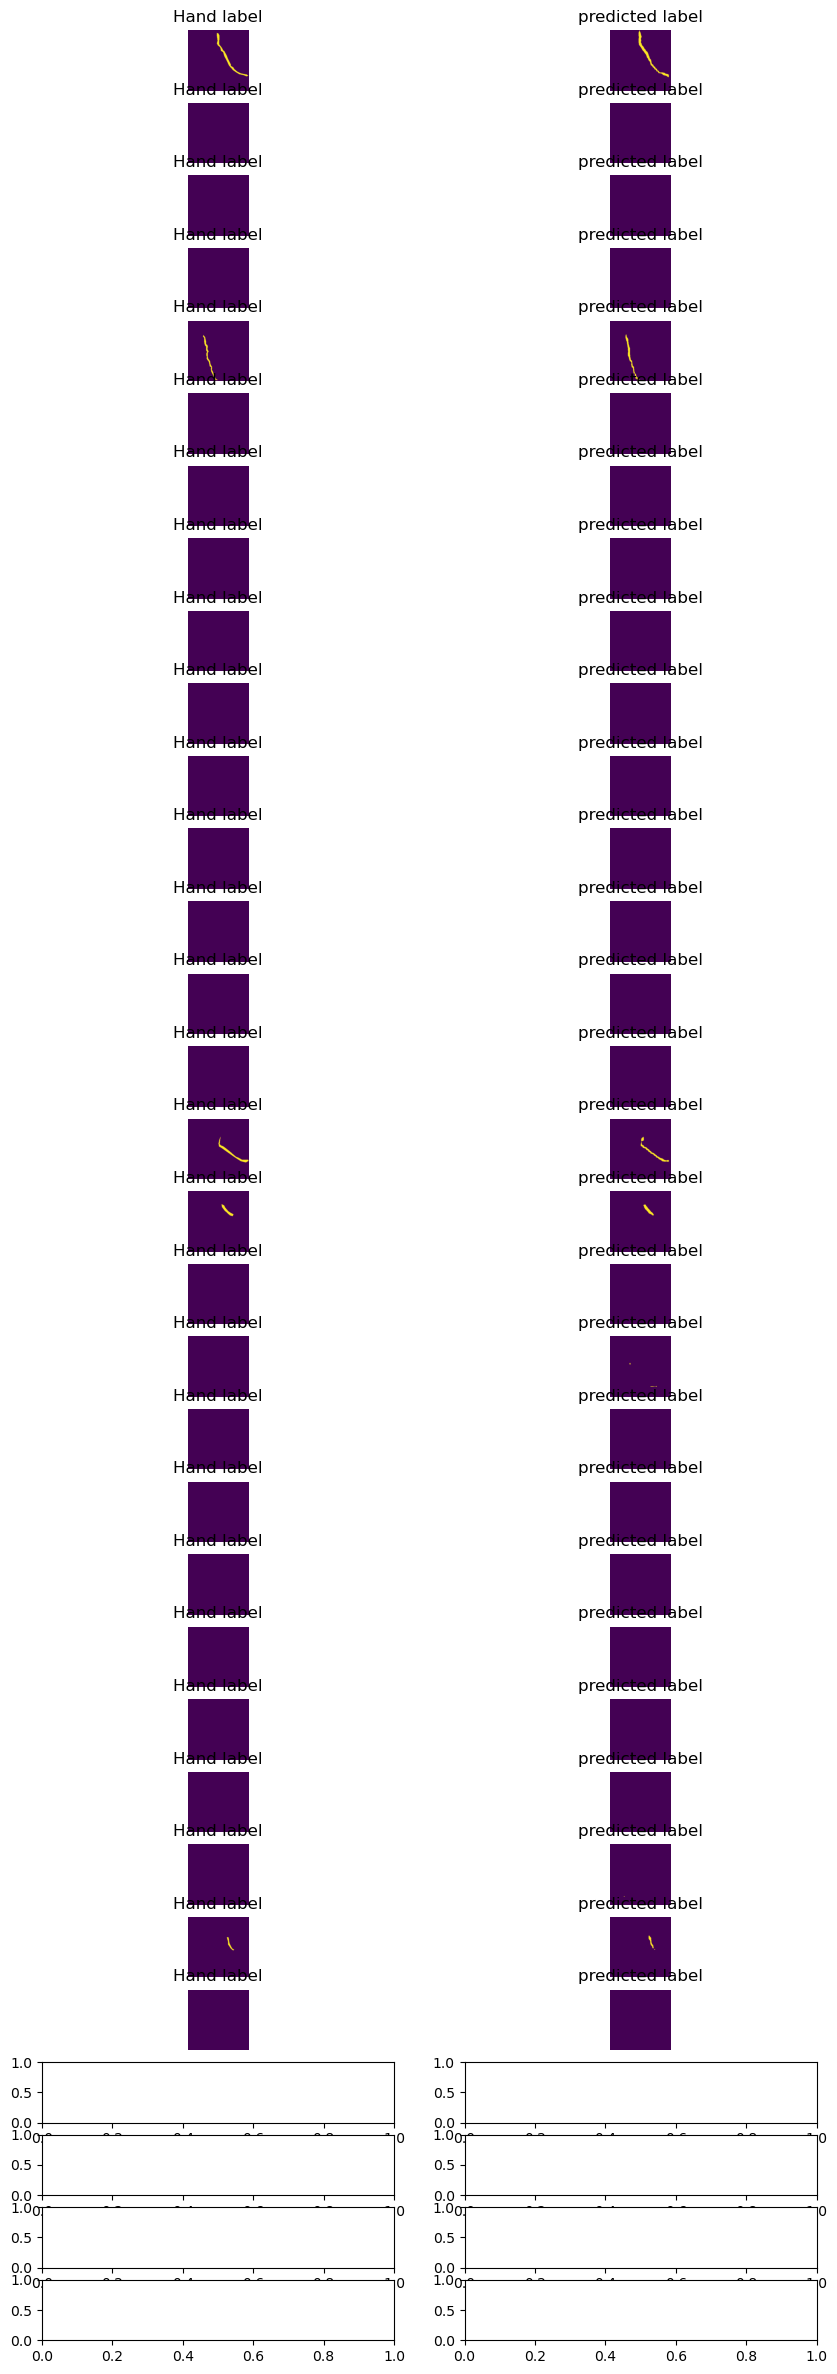

In [33]:
j = 1
with torch.no_grad():
    for image, target in dataloader_test:
        image = image.to(device)
        target = target.numpy()
        target_pred = model(image)['out'].detach().cpu().numpy()
        print(target_pred.shape)
        image = image.cpu().numpy()
        fig, ax = plt.subplots(32, 2, figsize=(10, 30))
        for i in range(32):
            #ax[i, 0].imshow(
            #    np.transpose(image[i], [2, 1, 0]),
            #    cmap='Spectral_r')
            #ax[i, 0].axis('off')
            #ax[i, 0].set_title('Rad')
            ax[i, 0].imshow(target[i])
            ax[i, 0].axis('off')
            ax[i, 0].set_title('Hand label')
            ax[i, 1].imshow(target_pred[i].argmax(axis=0))
            ax[i, 1].axis('off')
            ax[i, 1].set_title('predicted label')
        fig.tight_layout()
        fig.savefig(f'lake_breeze_validations/{j}.png', bbox_inches='tight')
        plt.close(fig)
        j = j + 1